In [16]:
!pip install netCDF4

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import netCDF4 as nc

In [3]:
nc

<module 'netCDF4' from '/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/netCDF4/__init__.py'>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def find_files(directory, prefix):
    """
    Find files in a directory that start with a specified prefix.

    Args:
        directory (str): The directory path to search for files.
        prefix (str): The prefix that the filenames should start with.

    Returns:
        list: A list of file paths matching the specified prefix.
    """
    matching_files = []
    for filename in os.listdir(directory):
        if filename.startswith(prefix):
            matching_files.append(os.path.join(directory, filename))
    return matching_files

In [9]:
def gather_files(YYYY, DDD, HH):
    """
    Args:
        YYYY (str): year in YYYY format
        DDD (str): day in DDD format
        HH (str): hour in HH format

    Returns:
        dict: A dictionary containing —
                ROOT_PATH: the base abi path

                YYYY: year
                DDD: day of year
                HH: hour

                00: files for minute 00 in hour
                ...
                50: filea for minute 50 in hour

                L200: cloud top height file (full path) for minute 00 in hour
                ...
                L250: cloud top height file (full path) for minute 50 in hour
    """

    ABI_ = {
        "ROOT_PATH": None,

        "YYYY": None,
        "DDD": None,
        "HH": None,

        "00": [],
        "15": [],
        "30": [],
        "45": [],

        "L200": None,
        "L210": None,
        "L220": None,
        "L230": None,
        "L240": None,
        "L250": None
    }

    _ABI_PATH_ = "/css/geostationary/BackStage/GOES-16-ABI-L1B-FULLD/" + YYYY + "/" + DDD + "/" + HH

    for filename in os.listdir(_ABI_PATH_):
        if ABI_["ROOT_PATH"] == None:
            ABI_["ROOT_PATH"] = _ABI_PATH_
            ABI_["YYYY"] = filename[27:31]
            ABI_["DDD"] = filename[31:34]
            ABI_["HH"] = filename[34:36]
        MM = filename[36:38]
        ABI_[f"{MM}"].append(filename)

    return ABI_

In [10]:
def get_L1B_L2(abipaths, l2path, YYYY, DDD, HH):

    # ASSERT ALL ABI CHANNELS PRESENT !!!!!!!!!!!!!!!!!!!!
    # assert len(abipaths) == 8, "NOT ALL ABI FILES LOCATED"
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


    # LOAD EACH ABI CHANNEL IMAGE
    CHANNELS = []
    ROOT = "/css/geostationary/BackStage/GOES-16-ABI-L1B-FULLD/"

    for file in abipaths:
        L1B = np.array(nc.Dataset(ROOT + "/" + YYYY + "/" + DDD + "/" + HH + "/" + file, 'r')["Rad"])
        CHANNEL = int(file[19:21])
        CHANNELS.append((L1B, CHANNEL))

    # SORT CHANNELS
    CHANNELS.sort(key=lambda x: x[1])
    CHANNELS = [C[0] for C in CHANNELS]

    T = []
    #RESIZE ALL CHANNELS TO SAME SIZE
    for C in CHANNELS:
        S = C.shape[0] // 5424
        if S != 1: C = C[::S, ::S]
        T.append(C)

    CHANNELS = T

    # STACK ABI CHANNELS INTO SINGLE IMAGE
    ABI = np.stack(CHANNELS, axis=2)

    return ABI

In [11]:
# TEST gather_files() FUNCTION
DATA = gather_files("2017", "218", "18")
DATA

{'ROOT_PATH': '/css/geostationary/BackStage/GOES-16-ABI-L1B-FULLD/2017/218/18',
 'YYYY': '2017',
 'DDD': '218',
 'HH': '18',
 '00': ['OR_ABI-L1b-RadF-M3C04_G16_s20172181800375_e20172181811142_c20172181811162.nc',
  'OR_ABI-L1b-RadF-M3C15_G16_s20172181800375_e20172181811148_c20172181811203.nc',
  'OR_ABI-L1b-RadF-M3C06_G16_s20172181800375_e20172181811147_c20172181811183.nc',
  'OR_ABI-L1b-RadF-M3C01_G16_s20172181800375_e20172181811142_c20172181811188.nc',
  'OR_ABI-L1b-RadF-M3C07_G16_s20172181800375_e20172181811153_c20172181811187.nc',
  'OR_ABI-L1b-RadF-M3C11_G16_s20172181800375_e20172181811142_c20172181811200.nc',
  'OR_ABI-L1b-RadF-M3C09_G16_s20172181800375_e20172181811147_c20172181811202.nc',
  'OR_ABI-L1b-RadF-M3C14_G16_s20172181800375_e20172181811142_c20172181811202.nc',
  'OR_ABI-L1b-RadF-M3C10_G16_s20172181800375_e20172181811153_c20172181811198.nc',
  'OR_ABI-L1b-RadF-M3C03_G16_s20172181800375_e20172181811142_c20172181811187.nc',
  'OR_ABI-L1b-RadF-M3C16_G16_s20172181800375_e201

In [12]:
# TEST DATA IS LOADED CORRECT W/ get_L1B_L2() FUNCTION
ABI = get_L1B_L2(DATA["00"], DATA["L200"], DATA["YYYY"], DATA["DDD"], DATA["HH"])

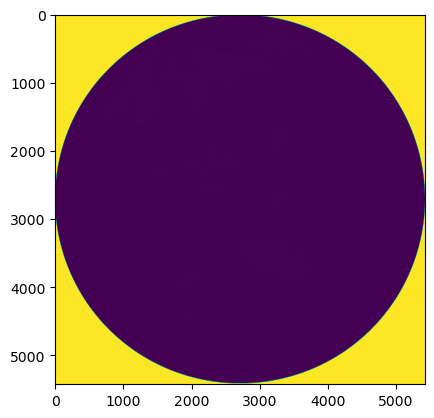

In [17]:
plt.imshow(ABI[..., 5])

BELOW ARE THE ABI CHANNELS LOADED IN PREVIOUS FUNCTIONS...


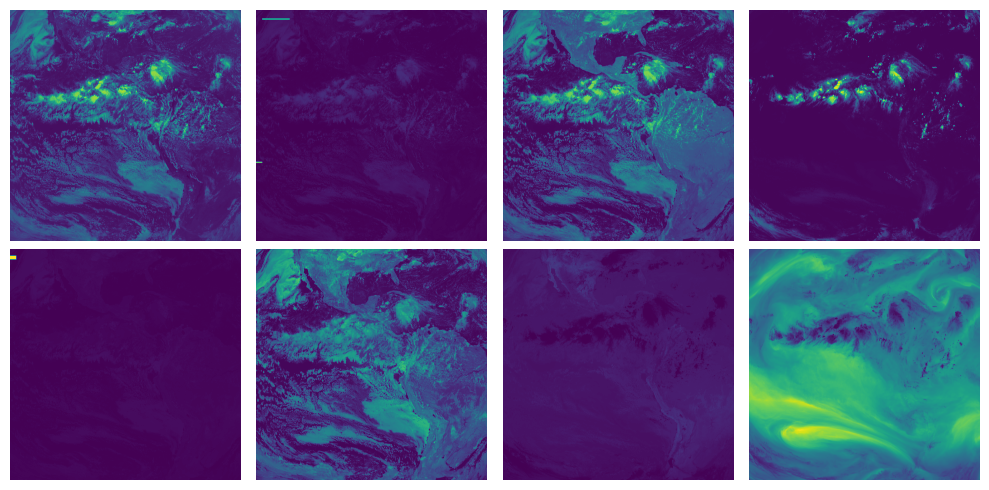

In [18]:
fig, ax = plt.subplots(2, 4, figsize=[10, 5])
C = 0
for i in range(2):
    for j in range(4):
        ax[i][j].axis("off")
        ax[i][j].imshow(ABI[800:5424-800, 800:5424-800, C])
        C += 1
fig.tight_layout()
print("BELOW ARE THE ABI CHANNELS LOADED IN PREVIOUS FUNCTIONS...")

BELOW IS THE L2 DATA LOADED IN PREVIOUS FUNCTIONS


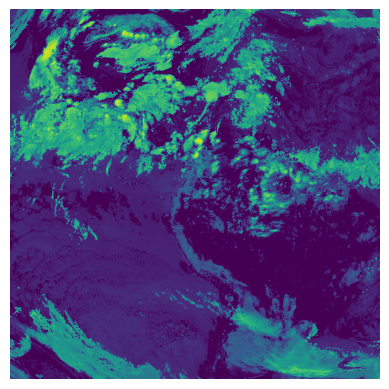

In [ ]:
plt.imshow(L2CT[800:5424-800, 800:5424-800])
plt.axis("off")
print("BELOW IS THE L2 DATA LOADED IN PREVIOUS FUNCTIONS")

In [ ]:
def get_uniform_sample(L2, N):
    # GET MASK FOR LOW CLOUDS AND HIGH CLOUDS
    no = L2 < 100
    low = np.logical_and(L2 > 100, L2 < 5000)
    high = L2 > 5000

    # CREATE COMBINED MASK TO SAMPLE COORDINATES FROM
    MASK = np.zeros_like(high).astype(float)
    MASK[low] = 0.5
    MASK[high] = 1

    # BOUNDS TO SAMPLE FROM
    BOUNDS = (1000, 5424-1000)

    # GENERATE 2*N COORDINATES AND ENSURE BALANCED DISTRIBUTION
    Xs = np.random.uniform(BOUNDS[0], BOUNDS[1], int(2 * N)).astype(int)
    Ys = np.random.uniform(BOUNDS[0], BOUNDS[1], int(2 * N)).astype(int)

    coordinate_pairs = list(zip(Xs, Ys))

    no_coordinates = []
    low_coordinates = []
    high_coordinates = []

    for (x, y) in coordinate_pairs:
        cloud_type = MASK[x, y]

        if cloud_type == 0:  # NONE
            no_coordinates.append((x, y))

        elif cloud_type == 0.5:  # LOW
            if len(low_coordinates) > (1.25 * len(high_coordinates)):
                continue
            else:
                low_coordinates.append((x, y))

        else: # cloud_type == 1, HIGH
            if len(high_coordinates) > (1.25 * len(low_coordinates)):
                continue
            else:
                high_coordinates.append((x, y))

    print("NUM NO CLOUD COORDS: ", len(no_coordinates))
    print("NUM HIGH CLOUD COORDS: ", len(high_coordinates))
    print("NUM LOW CLOUD COORDS: ", len(low_coordinates))

    high_coordinates.extend(low_coordinates)
    high_coordinates.extend(no_coordinates)

    return high_coordinates


In [ ]:
# TEST get_uniform_sample() FUNCTION
Cs = get_uniform_sample(L2CT, 1000)

NUM NO CLOUD COORDS:  585
NUM HIGH CLOUD COORDS:  524
NUM LOW CLOUD COORDS:  656


In [ ]:
def save_chips(ABI, L2_CLOUDTOP, L2_UNCERTAINTY, L2_CLOUDMASK, L2LAT, L2LON, COORDINATES, DEST_DIR, USRN, YYYY, DDD, HH, MM, TESTRUN=False):

    directory = f"/explore/nobackup/people/{USRN}/{DEST_DIR}/{YYYY}/{DDD}/{HH}/{MM}/"

    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"DIR '{directory}' CREATED.")

    else:
        print(f"DIR '{directory}' ALREADY EXISTS.")

    for (x, y) in COORDINATES:
        # GET CHIP CENTERED ON COORDINATE
        chip = ABI[x-64:x+64, y-64:y+64, :]

        # GET ALL L2 INFORMATION
        CT = L2_CLOUDTOP[x-64:x+64, y-64:y+64]
        UN = L2_UNCERTAINTY[x-64:x+64, y-64:y+64]
        CM = L2_CLOUDMASK[x-64:x+64, y-64:y+64]

        # GET TAG INFORMATION
        L2V = L2_CLOUDTOP[x, y]

        if L2V < 100: tag = "NO"
        elif L2V < 5000: tag = "LOW"
        else: tag = "HIGH"

        single_stats = {"cloud_type": tag,
                 "latitude": L2LAT[x, y],
                 "longitude": L2LON[x, y],
                 "time": f"{YYYY}-{DDD}-{HH}-{MM}",
                }

        additional_data = {
                "cloud_top": CT,
                "cloud_top_uncertainty": UN,
                "cloud_mask": CM,
                }



        filename = "ABICHIP_L1B_L2_" + YYYY + DDD + HH + "_" + str(x) + "_" + str(y)

        np.savez(directory+filename, ABI=chip, L2=additional_data, EXTRA=single_stats)

        if TESTRUN:
            print("SAVED: ", filename, "IN: ", directory)
            break

    print("NUM SAVED CHIPS:", len(COORDINATES), "IN:", directory)

In [ ]:
def generate_chips(YYYY, DDD, HH, MM, DEST_DIR, USRN):
    DATA = gather_files(YYYY, DDD, HH)
    ABI, L2CT, L2UN, L2CM, L2LAT, L2LON = get_L1B_L2(DATA[MM], DATA["L2"+MM], DATA["YYYY"], DATA["DDD"], DATA["HH"])
    COORDS = get_uniform_sample(L2CT, 1000)
    save_chips(ABI, L2CT, L2UN, L2CM, L2LAT, L2LON, COORDS, DEST_DIR, USRN, DATA["YYYY"], DATA["DDD"], DATA["HH"], MM)

In [ ]:
generate_chips("2019", "226", "23", "00", "L2_chips", "dhubert1")

NUM NO CLOUD COORDS:  556
NUM HIGH CLOUD COORDS:  649
NUM LOW CLOUD COORDS:  731
DIR '/explore/nobackup/people/dhubert1/L2_chips/2019/226/23/' CREATED.
NUM SAVED CHIPS: 1936 IN: /explore/nobackup/people/dhubert1/L2_chips/2019/226/23/




```
THE BELOW CODE HAS NOT BEEN RUN AND MAY PRODUCE ERRORS,
USE IT AS A GUIDE TO UPDATE THE ABOVE generate_chips() FUNCTION

IT SHOULD BE FULLY FUNCTIONAL THOUGH...
```



In [ ]:
def generate_chips(YYYY, DDD, HH, DEST_DIR, USRN):
    assert False, "DOUBLE CHECK CODE THIS FUNCTION IS UNTESTED" # STOPS FUNCTION FROM RUNNING UNTIL MANUALLY REMOVED
    DATA = gather_files(YYYY, DDD, HH)
    # LOOP THROUGH MINUTES
    for MM in ["00", "10", "20", "30", "40", "50"]:
        ABI, L2CT, L2UN, L2CM, L2LAT, L2LON = get_L1B_L2(DATA[MM], DATA["L2"+MM], DATA["YYYY"], DATA["DDD"], DATA["HH"])
        COORDS = get_uniform_sample(L2CT, 1000) # 1000 IS NUMBER OF CHIPS PER FILESET
        save_chips(ABI, L2CT, L2UN, L2CM, L2LAT, L2LON, COORDS, DEST_DIR, USRN, DATA["YYYY"], DATA["DDD"], DATA["HH"], MM)



```
EXAMPLE PROCESS FOR ENTIRE DAY,
PSUEDOCODE!
```



In [ ]:
YYYY = _
DDD = _
DEST_DIR = _
USRN = _

# FOR EACH HOUR
for HH in [f"{HH:02}" for HH in range(23)]:
    # CHECK DIRECTORY EXISTS
    generate_chips(YYYY, DDD, HH, DEST_DIR, USRN)

# APPLY MORE OUTER LOOPS FOR MULTIPLE DAYS // YEARS

# IT MAY BE IMPORTANT TO CHANGE ASSERTIONS TO RETURN NULLS IN ORDER TO NOT HALT SCRIPT



```
SAMPLE CODE FOR LOADING DATA
```



In [ ]:
path_to_file = "NOOT/NOOT/NOOTNOOT.npz"

file = np.load(path_to_file, allow_pickle=True)

ABI_data = file["ABI"] # np.array
L2_data = file["L2"].item() # DICTIONARY OF {"cloud_top": np.array, "cloud_top_uncertainty": np.array, "cloud_mask": np.array}
meta_data = file["EXTRA"].item # DICTIONARY WITH KEYS "latitude", "longitude", (of center point), "time"